In [1]:
import numpy as np
import sqlite3
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from lmfit.models import GaussianModel
from functools import reduce
from lmfit import Parameter
from astropy.constants import c
from astropy.units import Quantity
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import re


h = 6.626*10**(-34)  # Planck's constant in J*s
h_csg = 6.62607015*10**(-27)  # Planck's constant in erg*s
k = 1.381*10**(-23)  # Boltzmann's constant in J/K
k_B = 1.380649*10**(-16)  # Boltzmann's constant in erg/K 
kcm = 0.69503476  # Boltzmann's constant in cm-1/K
ckm = 2.998*10**5  # peed of light in km/s
ccm = 2.998*10**10  # speed of light in cm/s
cm = 2.998*10**8  # speed of light in m/s

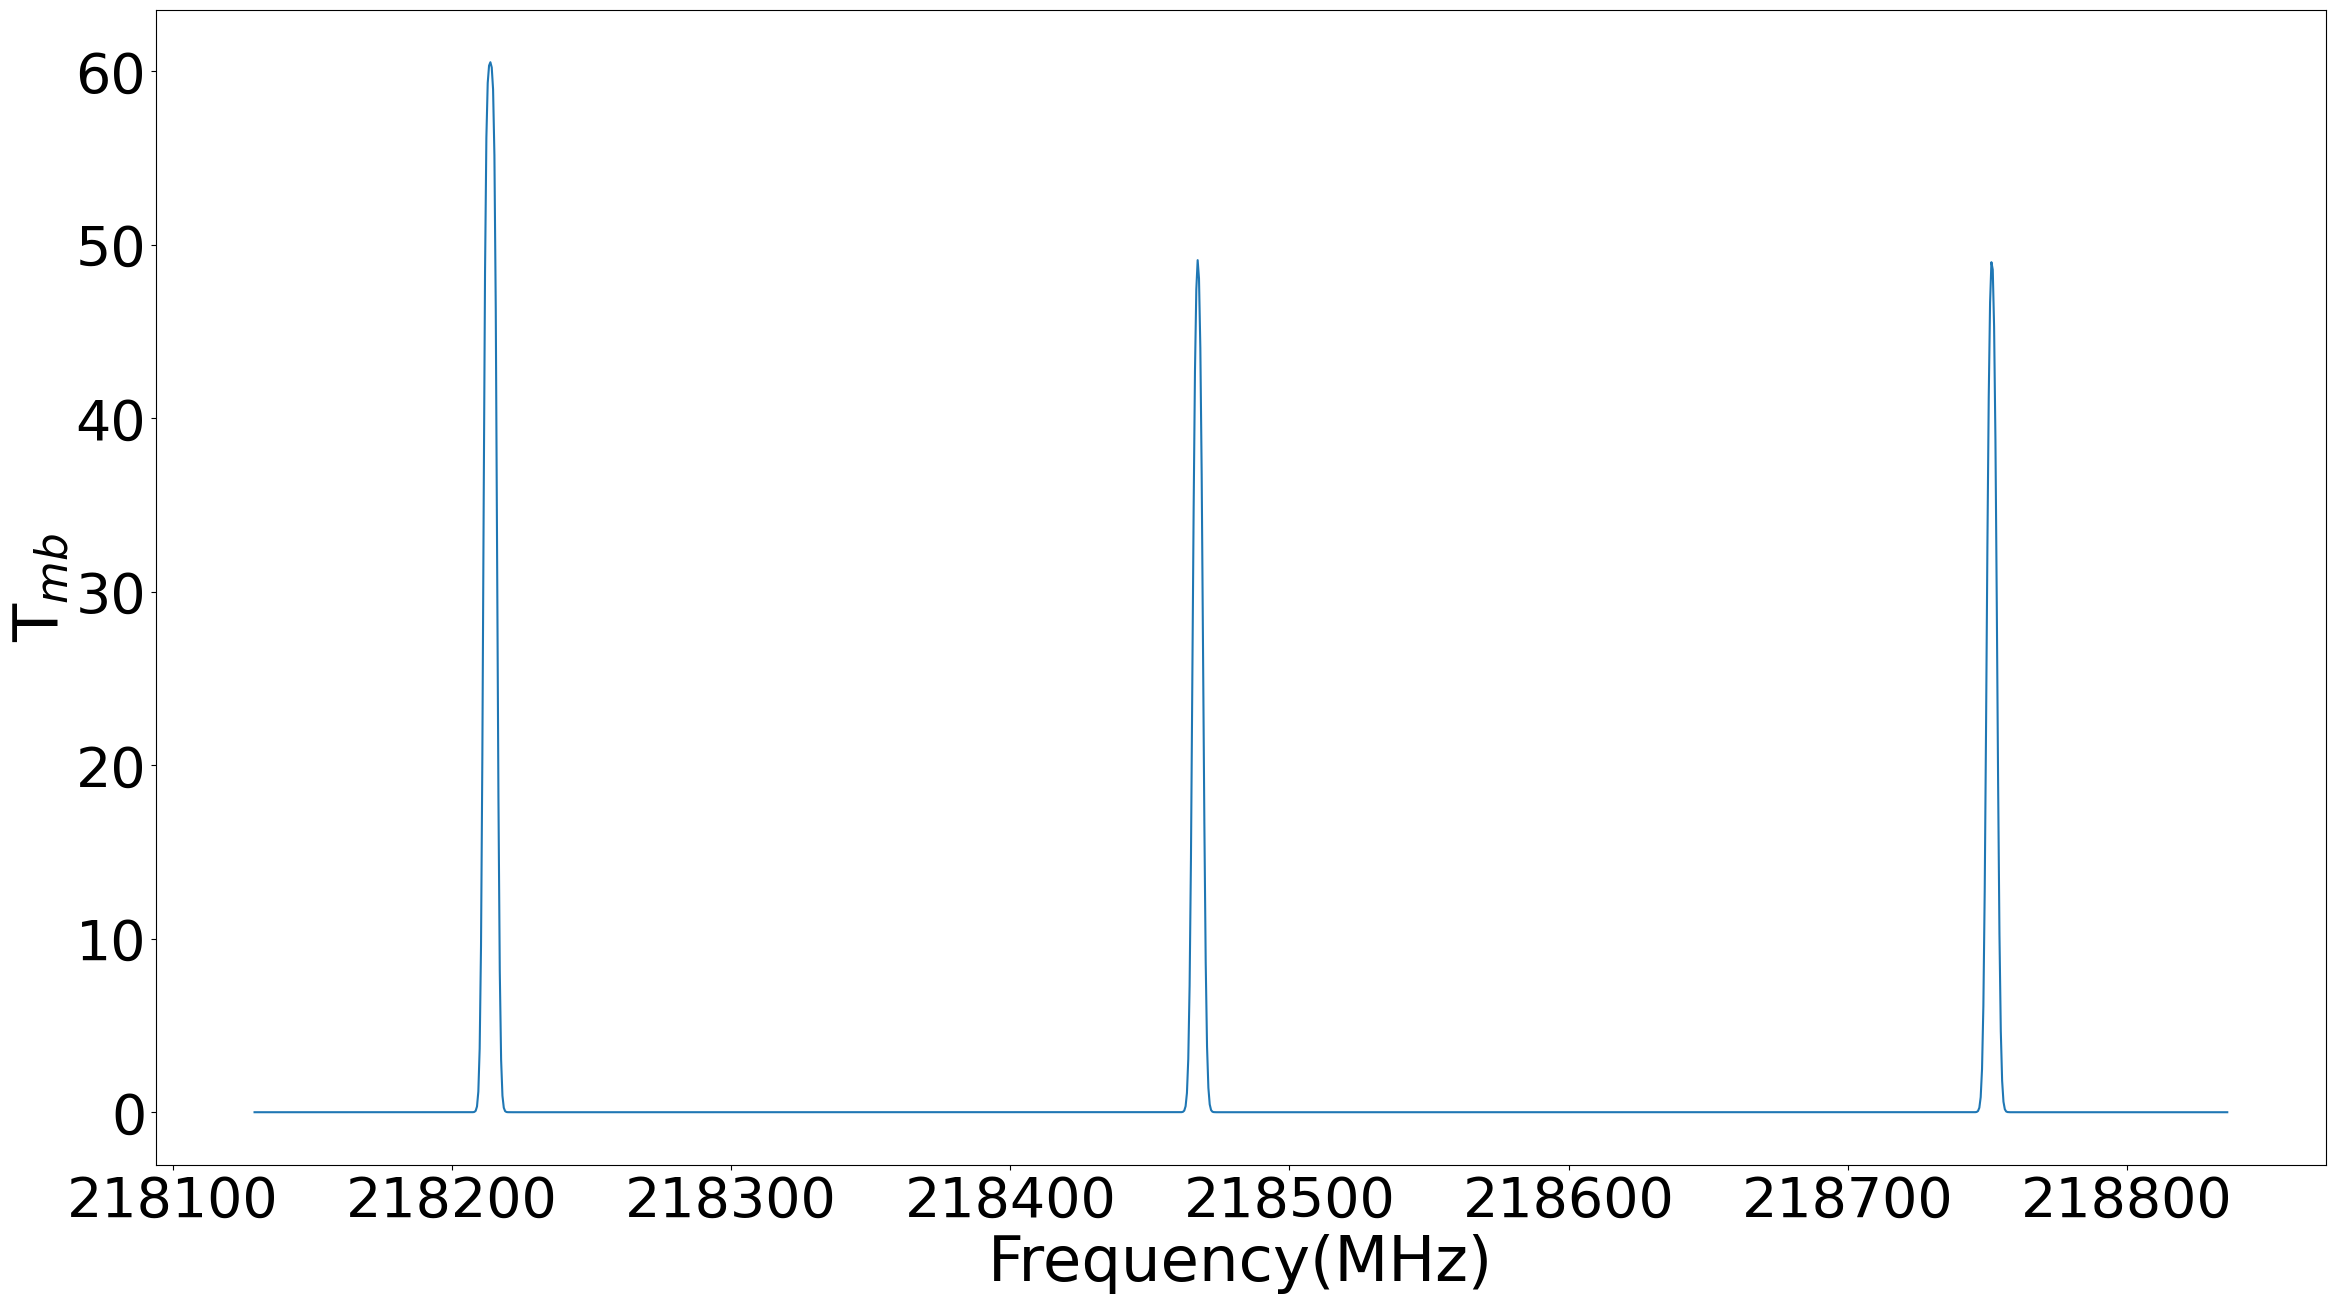

In [4]:
def gauss_fit(name, freq_l, freq_u, step, db_path, p, beam=None):


    # moculal parameters are taken from CDMS database
    def mole_info():

        mole_info = {}

        connection = sqlite3.connect(db_path)
        cursor = connection.cursor()
        
        query = """
        SELECT * FROM Transitions
        WHERE T_Name = ? 
        AND T_Frequency BETWEEN ? AND ?;
        """
        cursor.execute(query, (name, freq_l, freq_u))
        
        columns = [description[0] for description in cursor.description]
        
        results = [dict(zip(columns, row)) for row in cursor.fetchall()]
        for column in columns:
            mole_info[column] = [entry[column] for entry in results]


        query_pf = "SELECT * FROM Partitionfunctions WHERE PF_Name = ?"
        cursor.execute(query_pf, (name,))
        row = cursor.fetchone()

        columns = [desc[0] for desc in cursor.description]

        if not row:
            raise ValueError(f"No data found for molecule: {name}")

        pf_data = {}
        for key, value in zip(columns, row):
            if key.startswith("PF_") and re.match(r"PF_\d+_\d+", key):
                temp_str = key.split("_", 1)[1].replace('_', '.')
                try:
                    T = float(temp_str)
                    pf_data[T] = value
                except ValueError:
                    continue 

        cursor.close()
        connection.close()

        return mole_info, pf_data


    mole_info, pf_data = mole_info()

    # -------- partation function ------------
    def cal_q(T, pf_data):

        temps = np.array(sorted(pf_data.keys()))
        Qs = np.array([pf_data[T] for T in temps])

        f_interp = interp1d(temps, Qs, kind='linear', bounds_error=True)

        Q = f_interp(T)

        return Q
    

    # -------- beam filling factor ------------
    def apply_beam(beam):
        
        filling_factor = p[0]**2 / (p[0]**2+beam**2)

        return filling_factor
    

    # -------- molecular parameters ------------
    pf = cal_q(p[1], pf_data)  
    mole_info = mole_info
    gu = np.array(mole_info['T_UpperStateDegeneracy'])
    El = np.array(mole_info['T_EnergyLower'])  # cm -1
    Aul = np.array(mole_info['T_EinsteinA']) 
    v0 = np.array(mole_info['T_Frequency'])*1e6  # Hz


    T_sim = []
    pro_tau = []
    freq_tau = []


    # -------- LTE Model ------------
    for i in range(len(v0)):

        sigma = ((p[3]/ckm)*v0[i]) / (2*np.sqrt(2*np.log(2)))  # Hz
        v_delta = -((p[4]/ckm) * v0[i])  # Hz 
        v_obs = v0[i] + v_delta  # Hz
        v = np.arange(v_obs-10*np.abs(v_delta), v_obs+10*np.abs(v_delta), step*1e6)  # Hz 
        
        for j in v: 

            phijk = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-(((j - v_obs)**2) / (2*sigma*sigma))) 
            tau_0 = ccm**2 / (8*np.pi*j*j)  
            tau_1 =Aul[i]*p[2]*((gu[i]*np.exp(-El[i]/(kcm*p[1]))) / pf)
            tau_2 = 1 - np.exp((-h_csg*j) / (k_B*p[1]))
            tau = tau_0*tau_1*tau_2*phijk
            pro_tau.append(tau)
            freq_tau.append(j*1e-6)

# -------------- 1D radiative transfer eqution ------------------
            filling_factor = apply_beam(beam)
            J_T = ((h_csg*j/k_B) / (np.exp(h_csg*j / (k_B*p[1])) - 1)) * (1 - np.exp(-tau))
            J_Tbg = ((h_csg*j/k_B) / (np.exp(h_csg*j / (k_B*2.73)) - 1)) * (np.exp(-tau) - 1)
            T_sim_tmp = filling_factor * (J_T + J_Tbg)
            T_sim = np.append(np.array(T_sim), T_sim_tmp)


    plt.figure(figsize=(28, 15))
    plt.plot(freq_tau, T_sim)
    plt.xlabel("Frequency(MHz)", fontsize=45)
    plt.ylabel("T$_{mb}$", fontsize=45)
    plt.tick_params(axis='both', which='both', labelsize=40)
    plt.show()

    return freq_tau, T_sim


freq_tau, T_sim = gauss_fit(name='H2CO;v=0;', freq_l=218000, freq_u=219000, step=0.48, db_path='./cdms_lite__official.db', p=[0.43, 112, 7.9e16, 4.2, 11.6], beam=0.37)

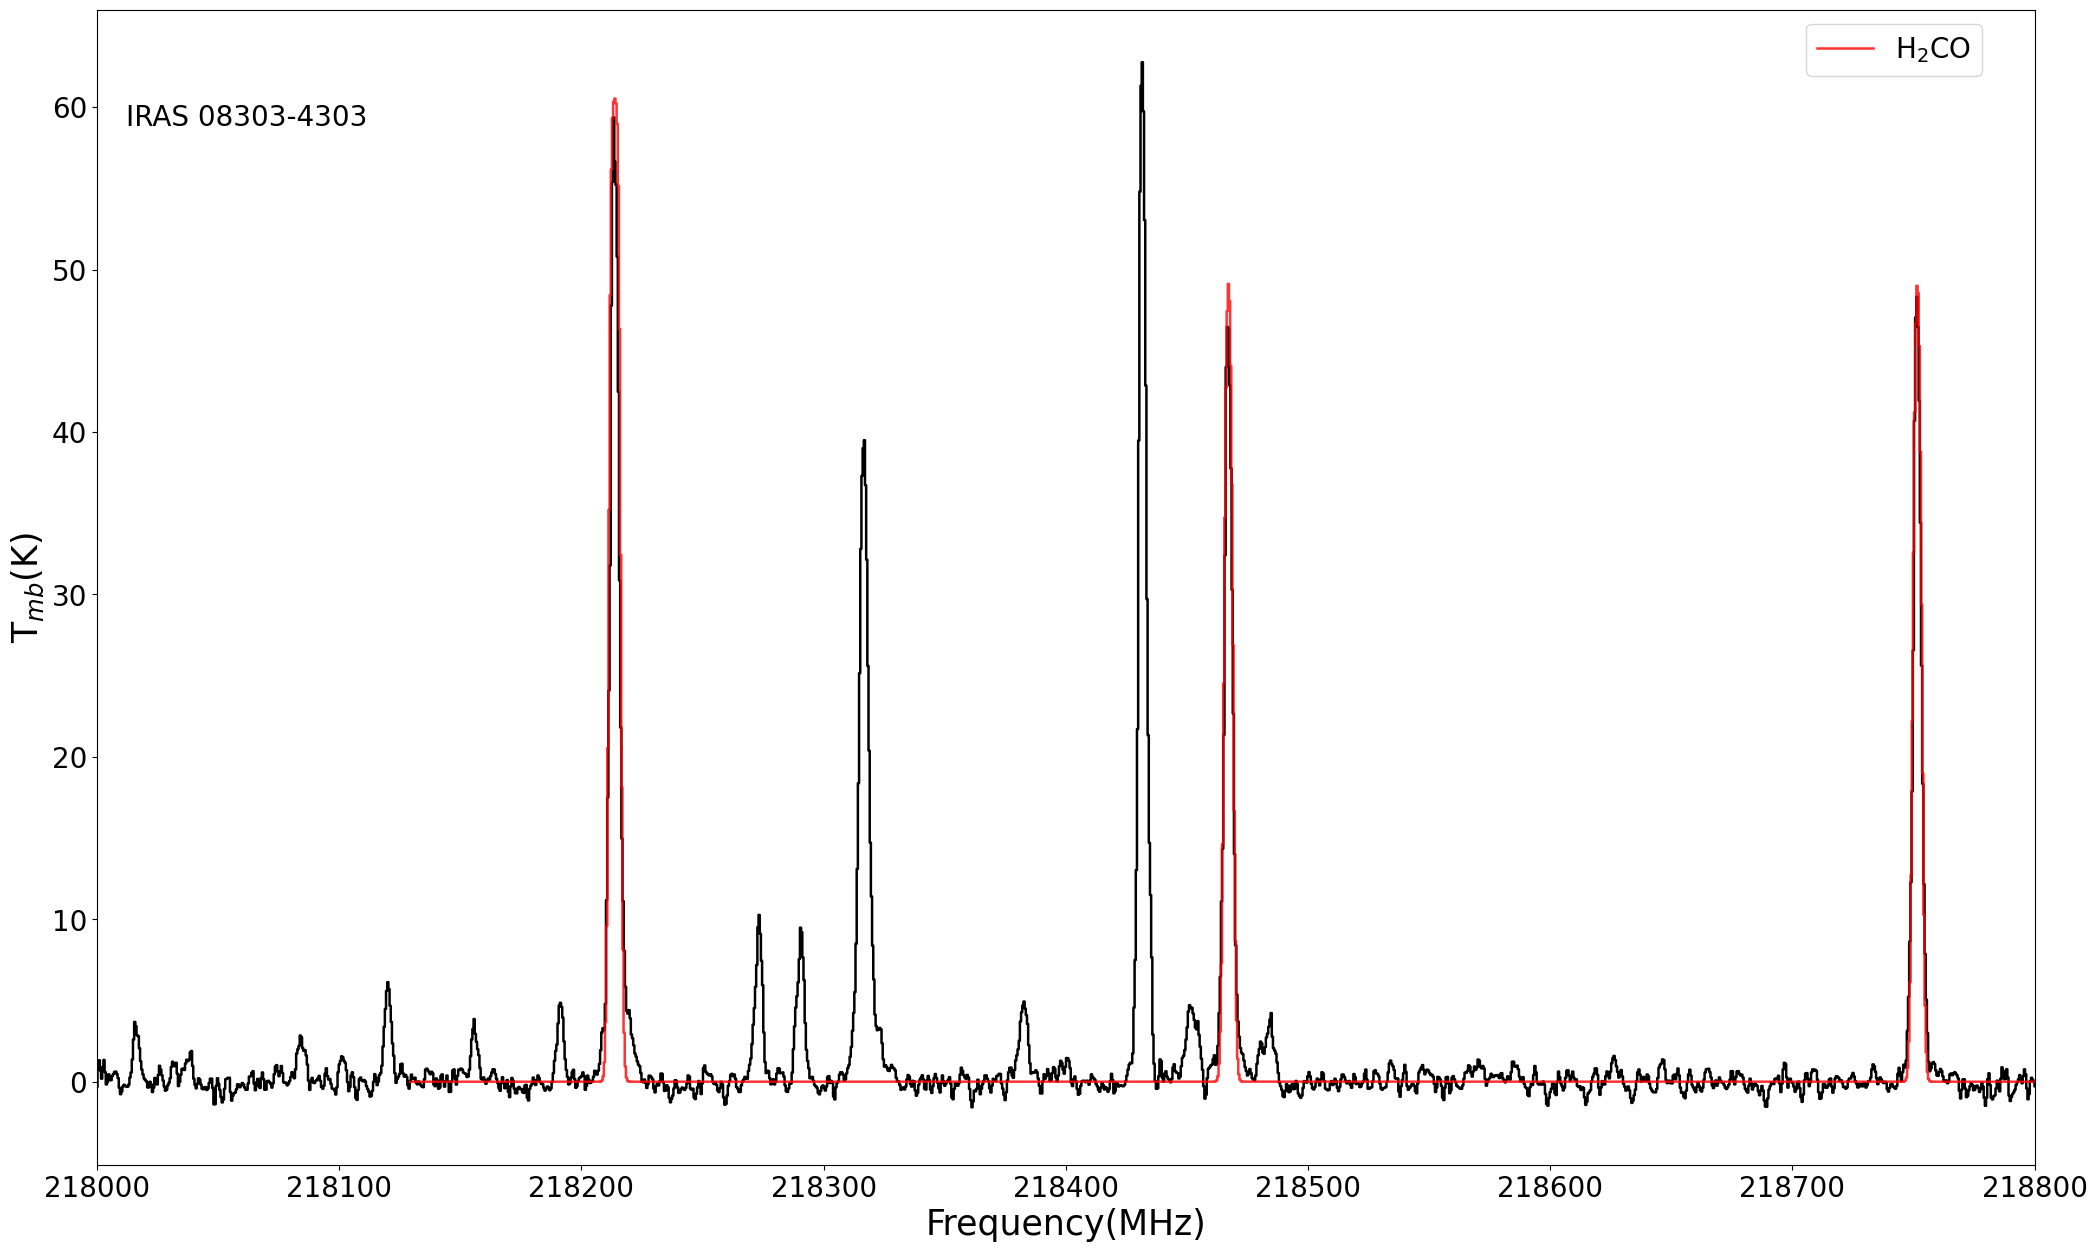

In [5]:
file_path_37 = "./C1spw0_source.tsv"
x_data_37 = []
y_data_37 = []
column1_data_37 = []
column2_data_37 = []

with open(file_path_37, 'r') as file_37:
    lines_37 = file_37.readlines()
    for line_37 in lines_37[11:]:
        columns_37 = line_37.split()
        column1_data_37.append(columns_37[0])
        column2_data_37.append(columns_37[1])

for x, y in zip(column1_data_37, column2_data_37):
    temp_x = float(x)
    temp_y = float(y)
    x_data_37.append(temp_x)
    y_data_37.append(temp_y)

x_data_37 = np.array(x_data_37)
y_data_37 = np.array(y_data_37)


plt.figure(figsize=(25, 15))
plt.xlim(218000, 218800)
plt.plot(x_data_37, y_data_37, color='black', linewidth=1.8, drawstyle='steps-mid')
plt.plot(freq_tau, T_sim, color='red', linewidth=1.8, alpha=0.8, label='H$_2$CO', drawstyle='steps-mid')
legend = plt.legend(loc='upper right', bbox_to_anchor=(0.98, 1.0), fontsize=20, ncol=1)
line = legend.get_lines()
# line[0].set_linewidth(1.5), line[1].set_linewidth(1.5)
plt.xlabel("Frequency(MHz)", fontsize=25)
plt.ylabel("T$_{mb}$(K)", fontsize=25)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.text(0.015, 0.90, "IRAS 08303-4303", fontsize=20, transform=plt.gca().transAxes)
plt.subplots_adjust(wspace=0.1)
plt.show()